# kaggle titanic 

### 准备工作

In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# 模型相关
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

### 获取数据

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
combine = [train_df, test_df]

In [3]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 区分数值和类别数据

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


其中Age, Fare是连续性行数据， SibSp， Patch是离散型数据。 而Survived， Sex， Embarked是类别数据， 而Pclass是顺序性类别。

In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### 空值，不存在的特征

In [6]:
train_df.info()
print("-"* 40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

Age部分缺失(考虑补全)，Cabin部分缺失(考虑删除)

### 数值型特征的分布

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 类别型特征的分布


In [8]:
train_df.describe(include=[np.object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Cor, Mr. Liudevit",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## 假设性数据分析

首先基于数据做基本的假设，后续进一步处理时验证这些假设。


In [9]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
train_df[["SibSp", "Survived"]].groupby(["SibSp"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train_df[["Parch", "Survived"]].groupby(["Parch"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 可视化数据分析

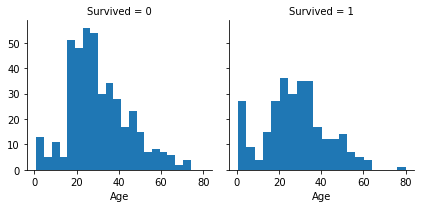

In [13]:
grid = sns.FacetGrid(train_df, col="Survived")
grid.map(plt.hist, "Age", bins=20)

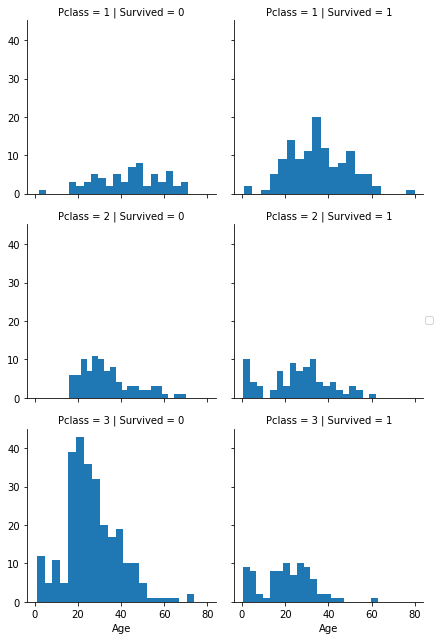

In [14]:
grid = sns.FacetGrid(train_df, col="Survived", row='Pclass')
grid.map(plt.hist, "Age", bins=20)
grid.add_legend()

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


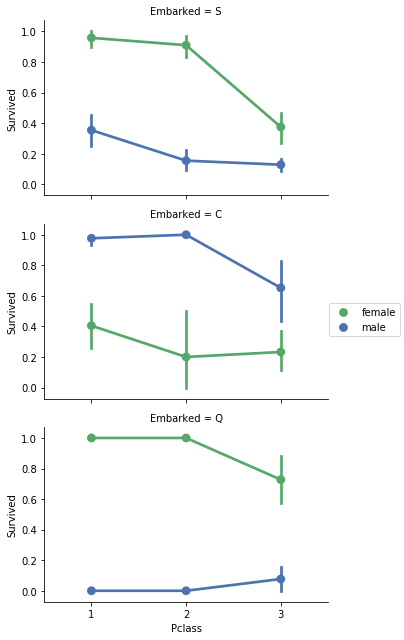

In [15]:
grid = sns.FacetGrid(train_df, row="Embarked", aspect=1.6)
grid.map(sns.pointplot, "Pclass", "Survived", "Sex",  palette="deep")
grid.add_legend()

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


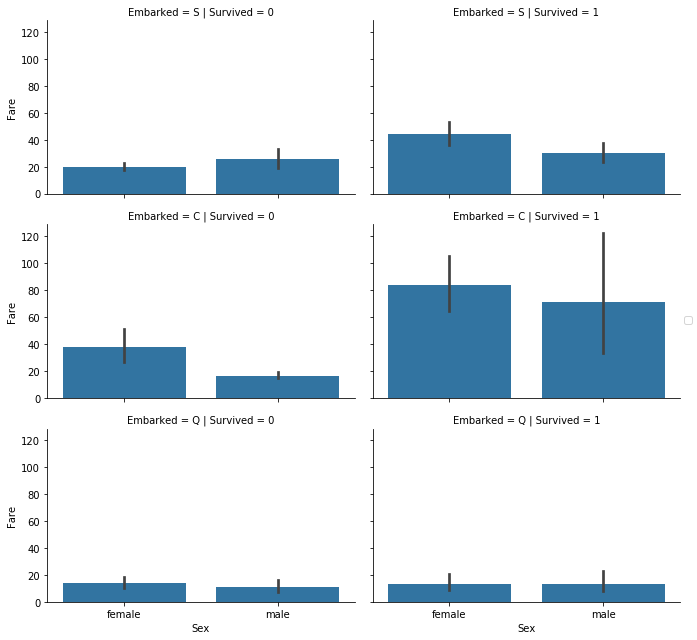

In [16]:
grid = sns.FacetGrid(train_df, row="Embarked",col="Survived", aspect=1.6)
grid.map(sns.barplot, "Sex", "Fare")
grid.add_legend()

## 补全上述的假设关系
### 删除无用的特征

In [17]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(["Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["Ticket", "Cabin"], axis = 1)
combine = [train_df, test_df]
print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


### 从现有特征创造新特征

In [18]:
for dataset in combine:
    dataset["Title"] = dataset["Name"].str.extract('([A-Za-z]+)\.', expand=False)

In [19]:
pd.crosstab(train_df["Title"], train_df["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [20]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### 对类别名字进行编码

In [21]:
title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
for dataset in combine:
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [23]:
# 删除姓名特征
train_df = train_df.drop(["Name", "PassengerId"], axis=1)
test_df = test_df.drop(["Name"], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### 对性别类别信息进行编码

In [24]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({"female": 1, "male": 0}).astype(int)
train_df.head()
                                        

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## 完善连续性数值特征

In [25]:
# grid = sns.FacetGrid(train_df, row="Pclass", col="Sex", aspect=1.6)
# grid.map(plt.hist, 'Age', bins=20)
# grid.add_legend()

In [26]:
guess_ages = np.zeros((2, 3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [27]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset["Sex"] == i) & (dataset["Pclass"] == j + 1)]["Age"].dropna()
#             age_mean = guess_df.mean()
#             age_std = guess_df.std()
#             age_guess = rnd.uniform(age.mean - age_std, age_mean + age_std)
            age_guess = guess_df.median()
#             print(age_guess)
            guess_ages[i, j] = int(age_guess/0.5 + 0.5) * 0.5
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


## 对Age分组统计

In [28]:
train_df["AgeBand"] = pd.cut(train_df["Age"], 5)
train_df[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean().sort_values(by="AgeBand", ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [29]:
for dataset in combine:
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [30]:
# 删除 AgeBand 特征
train_df = train_df.drop(["AgeBand"], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


## 根据现有特征创建新特征
利用兄弟姐妹数量和配偶数量来作为亲戚指标

In [31]:
for dataset in combine:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
train_df[["FamilySize", "Survived"]].groupby(["FamilySize"], as_index=False).mean().sort_values(by="Survived",ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [32]:
# 创建另一个特征
for dataset in combine:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "IsAlone"] = 1
train_df[["IsAlone", "Survived"]].groupby(["Survived"], as_index=False).mean()

,Survived,IsAlone
0,0,0.681239
1,1,0.476608


In [33]:
# 移除无用的几个特征
train_df = train_df.drop(["Parch", "SibSp", "FamilySize"], axis = 1)
test_df = test_df.drop(["Parch", "SibSp", "FamilySize"], axis = 1)
combine = [train_df, test_df]

In [34]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [35]:
# 创建Pclass*Age特征
for dataset in combine:
    dataset["Age*Pclass"] = dataset["Age"] * dataset["Pclass"]
train_df.loc[:, ["Age*Pclass", "Age", "Pclass"]].head(10)

,Age*Pclass,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


## 完善类别信息

In [36]:
freq_port = train_df["Embarked"].dropna().mode()[0]
freq_port

'S'

In [37]:
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].fillna(freq_port)
train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [38]:
# 对该特征进行编码转换
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q":2}).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Pclass
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


## 快速补全和完善数值特征

In [39]:
test_df["Fare"].fillna(test_df["Fare"].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Pclass
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [40]:
# 对 Fare 进行区间分类
train_df["FareBand"] = pd.qcut(train_df["Fare"], 4)
train_df[["FareBand", "Survived"]].groupby(["FareBand"], as_index=False).mean().sort_values(by="Survived",ascending=False)

,FareBand,Survived
3,"(31.0, 512.329]",0.581081
2,"(14.454, 31.0]",0.454955
1,"(7.91, 14.454]",0.303571
0,"(-0.001, 7.91]",0.197309


In [41]:
# 进行区间转换
for dataset in combine:
    dataset.loc[dataset["Fare"] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)

In [42]:
train_df = train_df.drop(["FareBand"], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Pclass
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [43]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Pclass
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


## 模型，训练和预测

In [44]:
X_train = train_df.drop(["Survived"], axis = 1)
Y_train = train_df["Survived"]
X_test = test_df.drop(["PassengerId"], axis = 1)
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [45]:
def clf_score(clf, X, Y):
    clf.fit(X_train, Y_train)
    score = clf.score(X, Y)
    print(score)

In [46]:
# 逻辑回归
logreg  = LogisticRegression()
clf_score(logreg, X_train, Y_train)

0.8125701459034792


In [47]:
# 特征的重要性
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by="Correlation", ascending=False)

,Feature,Correlation
1,Sex,2.200978
5,Title,0.414362
4,Embarked,0.281026
6,IsAlone,0.262084
3,Fare,-0.022062
7,Age*Pclass,-0.085959
2,Age,-0.371647
0,Pclass,-1.083515


In [48]:
# svm
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = svc.score(X_train, Y_train)
acc_svc

0.835016835016835

In [49]:
# knn
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = knn.score(X_train, Y_train)
acc_knn

0.8406285072951739

In [50]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = gaussian.score(X_train, Y_train)
acc_gaussian

0.7687991021324355

In [51]:
# 感知机
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = perceptron.score(X_train, Y_train)
acc_perceptron

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.7878787878787878

In [52]:
# 线性svc
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = linear_svc.score(X_train, Y_train)
acc_linear_svc

0.7946127946127947

In [53]:
# 随机梯度下降分类器
sgd = SGDClassifier()
clf_score(sgd, X_train, Y_train)

0.7665544332210998


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [54]:
decision_tres = DecisionTreeClassifier()
clf_score(decision_tres, X_train, Y_train)

0.8664421997755332


In [55]:
random_forest = RandomForestClassifier(n_estimators=100)
clf_score(random_forest, X_train, Y_train)

0.8664421997755332


In [58]:
# tensorflow
import tensorflow as tf
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[10, 10], n_classes=2, 
                                         optimizer=tf.train.AdamOptimizer(1e-4),
                                         feature_columns=feature_columns)
dnn_clf.fit(x=X_train, y=Y_train, batch_size=2, steps=5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c24dec978>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/j0/mlln6qvj2kl42rr7mg80lsxc0000gn/T/tmpbyq4w1hb'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est

INFO:tensorflow:global_step/sec: 799.814
INFO:tensorflow:loss = 0.26431206, step = 3601 (0.126 sec)
INFO:tensorflow:global_step/sec: 751.456
INFO:tensorflow:loss = 0.26573646, step = 3701 (0.132 sec)
INFO:tensorflow:global_step/sec: 843.525
INFO:tensorflow:loss = 0.2766685, step = 3801 (0.119 sec)
INFO:tensorflow:global_step/sec: 814.936
INFO:tensorflow:loss = 0.9267185, step = 3901 (0.123 sec)
INFO:tensorflow:global_step/sec: 733.698
INFO:tensorflow:loss = 0.56092095, step = 4001 (0.136 sec)
INFO:tensorflow:global_step/sec: 728.851
INFO:tensorflow:loss = 0.3406698, step = 4101 (0.138 sec)
INFO:tensorflow:global_step/sec: 685.679
INFO:tensorflow:loss = 0.7746617, step = 4201 (0.146 sec)
INFO:tensorflow:global_step/sec: 793.519
INFO:tensorflow:loss = 0.35114184, step = 4301 (0.126 sec)
INFO:tensorflow:global_step/sec: 712.702
INFO:tensorflow:loss = 0.8450434, step = 4401 (0.141 sec)
INFO:tensorflow:global_step/sec: 745.389
INFO:tensorflow:loss = 1.4820819, step = 4501 (0.134 sec)
INFO:t

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x1c24dec828>, 'hidden_units': [10, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x1c24dec6d8>, 'activation_fn': <function relu at 0x1a165c4e18>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

## 结果输出

In [56]:
# Y_pred = decision_tres.predict(X_test)
# submission = pd.DataFrame({
#     "PassengerId":test_df["PassengerId"],
#     "Survived":Y_pred
# })
# submission.to_csv("submission.csv", index=False)

In [60]:
predict_y = list(dnn_clf.predict(X_test))
result =pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predict_y
    })
result.to_csv("result.csv", index=False)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/j0/mlln6qvj2kl42rr7mg80lsxc0000gn/T/tmpbyq4w1hb/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
